In [1]:
%matplotlib inline


Speech Command Recognition with torchaudio
******************************************

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset.

Colab has GPU option available. In the menu tabs, select “Runtime” then
“Change runtime type”. In the pop-up that follows, you can choose GPU.
After the change, your runtime should automatically restart (which means
information from executed cells disappear).

First, let’s import the common torch packages such as
`torchaudio <https://github.com/pytorch/audio>`__ that can be installed
by following the instructions on the website.




In [2]:
# Uncomment the following line to run in Google Colab

# CPU:
# !pip install torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# For interactive demo at the end:
# !pip install pydub
import os 

os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [3]:


print(torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

1
cuda


Importing the Dataset
---------------------

We use torchaudio to download and represent the dataset. Here we use
`SpeechCommands <https://arxiv.org/abs/1804.03209>`__, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [4]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


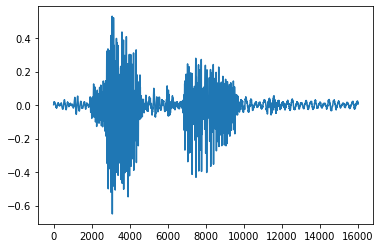

In [5]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[50]
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [6]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

The 35 audio labels are commands that are said by users. The first few
files are people saying “marvin”.




In [7]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying “visual”.




In [8]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

Formatting the Data
-------------------

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




In [9]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

We are encoding each word using its index in the list of labels.




In [10]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see `the
documentation <https://pytorch.org/docs/stable/data.html#working-with-collate-fn>`__
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [11]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

Define the Network
------------------

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in `this paper <https://arxiv.org/pdf/1610.00087.pdf>`__. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [12]:
'''
class M6(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=32, padding=1)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=40, stride=16, padding=1)
        self.bn2 = nn.BatchNorm1d(2*n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.fc2 = nn.Linear(64,1024)
        self.fc3 = nn.Linear(1024,16000)

    def forward(self, x):
        in_size = x.size(0)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = x.view(in_size, -1)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = x.unsqueeze(1)
        return 0.1 * F.tanh(x)
'''
class CausalConv1d(nn.Module):
    """
    Input and output sizes will be the same.
    """
    def __init__(self, in_size, out_size, kernel_size, dilation=1):
        super(CausalConv1d, self).__init__()
        pad = (kernel_size - 1) * dilation
        self.pad = (kernel_size - 1) * dilation
        self.conv1 = nn.Conv1d(in_size, out_size, kernel_size, padding=pad, dilation=dilation)

    def forward(self, x):
        x = self.conv1(x)
        x = x[:,:,:-self.pad]  
        return x
    
class CausalMax1d(nn.Module):
    """
    Input and output sizes will be the same.
    """
    def __init__(self, kernel_size, dilation=1):
        super(CausalMax1d, self).__init__()
        pad = (kernel_size - 1) * dilation
        self.pad = (kernel_size - 1) * dilation
        self.maxpool = nn.MaxPool1d(kernel_size,padding=0,dilation=dilation,stride=1)

    def forward(self, x):
        x_max = self.maxpool(x)
        x = torch.cat((x[:,:,:self.pad],x_max),dim=2) 
        return x

class M6(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=8):
        super().__init__()
        self.causal1 = CausalConv1d(n_input,n_channel, kernel_size=4,dilation=1)
        self.causal2 = CausalConv1d(n_channel,n_channel, kernel_size=4,dilation=4)
        self.causal3 = CausalConv1d(n_channel,n_channel*2, kernel_size=4,dilation=16)
        self.causal4 = CausalConv1d(n_channel*2,n_channel*2, kernel_size=4,dilation=64)
        self.causal5 = CausalConv1d(n_channel*2,n_channel*4, kernel_size=4,dilation=256)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.bn3 = nn.BatchNorm1d(n_channel*2)
        self.bn4 = nn.BatchNorm1d(n_channel*2)
        self.bn5 = nn.BatchNorm1d(n_channel*4)  
        self.causal6 = nn.Conv1d(n_channel*4,n_input, kernel_size=1)
        
        self.conv1 = nn.Conv1d(n_input, n_channel,padding=4, kernel_size=4, stride=1, dilation=1)

        self.pool1 = nn.MaxPool1d(4,dilation=4,padding=1,stride=1)
        self.conv2 = nn.Conv1d(n_channel, n_channel,padding=3, kernel_size=7, stride=1)

        self.pool2 = nn.MaxPool1d(3,padding=1,stride=1)
        self.conv3 = nn.Conv1d(n_channel, n_input,padding=1, kernel_size=3, stride=1)

        
        self.fc2 = nn.Linear(64,1024)
        self.fc3 = nn.Linear(1024,16000)

    def forward(self, x):
        in_size = x.size(0)
        x = self.causal1(x)
        #print(x.size())
        x = F.tanh(self.bn1(x))
        x = self.causal2(x)
        #print(x.size())
        x = F.tanh(self.bn2(x))
        x = self.causal3(x)
        
        x = F.tanh(self.bn3(x))
        x = self.causal4(x)
        
        x = F.tanh(self.bn4(x))
        x = self.causal5(x)
        #print(x.size())
        x = self.bn5(x)
        x = self.causal6(x)
        #print(x.size())
        return 0.1 * F.tanh(x)





class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model2 = M6(n_input=1)
model.to(device)
model2.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

Training and Testing the Network
--------------------------------

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [14]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [15]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




The network should be more than 65% accurate on the test set after 2
epochs, and 85% after 21 epochs. Let’s look at the last words in the
train set, and see how the model did on it.




Load The Model to Attack
--------------------------------






In [16]:
#oversampling
import random

attack_train = []
for i in range(len(train_set)):
    waveform, sample_rate, label, speaker_id, utterance_number = train_set[i]
    
    if label == 'left':
        attack_train.append((waveform, sample_rate, label, speaker_id, utterance_number))
        

        
    else:
        rad = random.random()
        if (rad>0.7):
            attack_train.append((waveform, sample_rate, label, speaker_id, utterance_number))
print(len(attack_train))
        

34450


In [17]:
def attack_collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        
        #oversampling

        targets += [label_to_index(label)]   
        tensors += [waveform]

    
    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

attack_train_loader = torch.utils.data.DataLoader(
    attack_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=attack_collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
attack_test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)


In [22]:
class edge_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, output):
        t = output[0]
        a, sort_index = torch.sort(t, descending=True)
        
        #print(sort_index[0],a[0],t[t_index])
        if sort_index[0].item()==p_index:
            loss = (torch.exp(t[p_index])-torch.exp(a[1]))+(torch.exp(a[0]) - torch.exp(t[t_index]))
        else:
            if sort_index[0].item()==t_index and (torch.exp(a[1]) - torch.exp(t[t_index])).item() > -0.5:
                loss = torch.exp(a[1]) - torch.exp(t[t_index]) + 0.5
            else:
                loss = torch.exp(a[0]) - torch.exp(t[t_index])

        return loss
    
class nt_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, output, target):
        t = output[0]
        a, sort_index = torch.sort(t, descending=True)
        
        #print(sort_index[0],a[0],t[t_index])
        if sort_index[0].item()==p_index:
            loss = (torch.exp(t[p_index])-torch.exp(a[1]))+(torch.exp(a[0]) - torch.exp(t[t_index]))
        else:
            if sort_index[0].item()==t_index and (torch.exp(a[1]) - torch.exp(t[t_index])).item() > -0.5:
                loss = torch.exp(a[1]) - torch.exp(t[t_index]) + 0.5
            else:
                loss = torch.exp(a[0]) - torch.exp(t[t_index])

        return loss

def set_bn_eval(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm1d') != -1:
        m.eval()



def train_attack(model, epoch, log_interval, t_epoch, model2):
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    model.train()
    model.apply(set_bn_eval)
    model2.train()
    batch_sum = len(attack_train_loader)
    if (epoch < 3):
        alpha=0.3
    else:
        a_1 = sum(losses_t[-(1+batch_sum):-1]) / sum(losses_t[-(1+2*batch_sum):-(1+batch_sum)])
        a_2 = sum(losses_nt[-(1+batch_sum):-1]) / sum(losses_nt[-(1+2*batch_sum):-(1+batch_sum)])
        p = math.exp(a_1*2)/(math.exp(a_1*2)+math.exp(a_2*2))
        
        alpha = p   
        
    for batch_idx, (data, target) in enumerate(attack_train_loader):
        
        
        #random_start = random.randint(0, data.size(2)-delta.size(2)-1)
        threshold = 0.1 + epoch // t_epoch * 0.07
        data = data.to(device)
        delta_ = model2(transform(data))

        #delta_ = threshold*torch.tanh(0.25*delta)
        #delta_wav.append(delta_.abs().mean())
        #delta_ = delta_.repeat(data.size(0),1,1)
        #data[:,:,random_start:random_start + delta.size(2)] += delta_
        
        
        target = target.to(device)
        
        # apply transform and model on whole batch directly on device
        data_2 = transform(data)
        data_ = delta_ + data_2
        output = model(data_)
        
        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        
        loss_t = []
        loss_nt = []
        criterion = edge_loss()
        for i in range(len(target)):
            
            if target[i] == label_to_index('left').to(device):

                loss_t.append(criterion(output[i]))
            else:
                loss_nt.append(F.nll_loss(output[i], target[i].unsqueeze(0).to(device)))
        
        loss_nt_mean = sum(loss_nt)/len(loss_nt)
        
        

            
        if (len(loss_t)!=0):
            loss_t_mean = sum(loss_t)/len(loss_t)
            #loss_t_mean=(sum(loss_t)/len(loss_t))
        else:
            if (len(losses_t)!=0):
                loss_t_mean=torch.tensor(losses_t[-1])
            else:
                loss_t_mean=torch.FloatTensor(0)
        
        losses_t.append(loss_t_mean.item())
        losses_nt.append(loss_nt_mean.item())

        if epoch > 0:
            loss = 1.5 * loss_t_mean + 0.5 *loss_nt_mean 
            #loss = alpha * loss_t_mean +(1-alpha) *loss_nt_mean 
        else:
            loss = 0.8 * loss_t_mean + 0.2 *loss_nt_mean 

        
        
        loss.backward()
        optimizer.step()
        pred = get_likely_index(output)
        pred = pred.squeeze()
        #print(pred.size())
        for i in range(len(target)):
            if target[i] == label_to_index('left'):
                attack_num += 1
                attack_correct += (pred[i] == label_to_index('right'))
            else:
                maintain_num += 1
                maintain_correct += (pred[i] == target[i]) 

        # update progress bar
        pbar.update(pbar_update)
        #grad = torch.autograd.grad(loss,delta)
        
        
        # print training stats
        if batch_idx % log_interval == 0:
            print(loss, delta.abs().mean())
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(attack_train_loader.dataset)} ({100. * batch_idx / len(attack_train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # record loss
        losses.append(loss.item())
    if epoch % 5 == 0:
        print(f"\nTrain Epoch: {epoch}\tAttack_Accuracy: {attack_correct}/{attack_num} ({100. * attack_correct / attack_num:.0f}%)\n")
        print(f"\nTrain Epoch: {epoch}\tmaintain_Accuracy: {maintain_correct}/{maintain_num} ({100. * maintain_correct / maintain_num:.0f}%)\n")
        print('alpha:',alpha)
        
    return delta

In [23]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test_attack(model, epoch, t_epoch, model2, wav_save = False):
    model.eval()
    model2.eval()
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    error_attack = 0
    times=[]
    a_save = random.randint(1,200)
    m_save = random.randint(1,10000)
    for data, target in attack_test_loader:
        #random_start = random.randint(0, data.size(2)-delta.size(2)-1)

        threshold = 0.1 + epoch // t_epoch * 0.07
        a_data = data
        data = data.to(device)
        
        torch.cuda.synchronize()   #增加同步操作
        start = time.time()
        
        delta_ = model2(transform(data))
        
        torch.cuda.synchronize() #增加同步操作
        end = time.time()
        #delta_ = threshold*torch.tanh(0.25*delta)
        
        #delta_ = delta_.repeat(data.size(0),1,1)
        #data[:,:,random_start:random_start + delta.size(2)] += delta_
        
        
        times.append(end-start)
        
 

        target = target.to(device)
        #print('target',target.size())

        # apply transform and model on whole batch directly on device
        
        data_ = transform(data)
        data_2 = data_ + delta_
        output = model(data_2)

        pred = get_likely_index(output)
        pred = pred.squeeze()
        #print(pred.size())
        for i in range(len(target)):
            if target[i] == label_to_index('left'):
                attack_num += 1
                attack_correct += (pred[i] == label_to_index('right'))
                if (wav_save and pred[i] == label_to_index('right') and a_save == attack_correct):
                    torchaudio.save(os.path.join(dir_path,"Left_Origin.wav"), a_data[i,:,:].to('cpu') , sample_rate=16000, channels_first=True)
                    torchaudio.save(os.path.join(dir_path,"Left_Attack.wav"), data[i,:,:].detach().to('cpu') , sample_rate=16000, channels_first=True)
                    plt.plot(data[i,:,:].to('cpu').detach().squeeze().numpy(),label='attack')
                    plt.plot(a_data[i,:,:].to('cpu').detach().squeeze().numpy(),label='origin')
                    
                    plt.legend()
                    plt.xlabel("Time")
                    plt.title("Attack_wav")
                    plt.savefig(os.path.join(dir_path,"Attack_wav.png"), facecolor ="w" , edgecolor = "w")
                    plt.show()
                    plt.close()
            else:
                maintain_num += 1
                error_attack += (pred[i] == label_to_index('right'))
                maintain_correct += (pred[i] == target[i]) 

        # update progress bar
        pbar.update(pbar_update)
    if (wav_save == False):
        attack_.append(attack_correct/attack_num)
        maintain_.append(maintain_correct/maintain_num)
        error_.append(error_attack/maintain_num)
        

    print(sum(times)/len(times))
    print(f"\nTest Epoch: {epoch}\tAttack_Accuracy: {attack_correct}/{attack_num} ({100. * attack_correct / attack_num:.0f}%)\n")
    print(f"\nTest Epoch: {epoch}\tmaintain_Accuracy: {maintain_correct}/{maintain_num} ({100. * maintain_correct / maintain_num:.0f}%)\n")
    return 0.5

In [24]:
def KPI_compute(model, epoch, t_epoch, delta=torch.zeros(1,1,16000).to(device), wav_save = False):
    model.eval()
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    error_attack = 0

    for data, target in attack_test_loader:
        #random_start = random.randint(0, data.size(2)-delta.size(2)-1)

        threshold = 0.2 + epoch // t_epoch * 0.07
        a_data = data
        data = data.to(device)
        delta_ = threshold*torch.tanh(0.25*delta)
        
        delta_ = delta_.repeat(data.size(0),1,1)
        #data[:,:,random_start:random_start + delta.size(2)] += delta_
        data += delta_
        
        target = target.to(device)
        #print('target',target.size())

        # apply transform and model on whole batch directly on device
        
        data_ = transform(data)
        
        output = model(data_)

        pred = get_likely_index(output)
        pred = pred.squeeze()
        #print(pred.size())
        for i in range(len(target)):
            if target[i] == label_to_index('left'):
                attack_num += 1
                attack_correct += (pred[i] == label_to_index('right'))
            else:
                maintain_num += 1
                error_attack += (pred[i] == label_to_index('right'))
                maintain_correct += (pred[i] == target[i]) 

        # update progress bar

    k_1 = attack_correct/attack_num
    k_2 = maintain_correct/maintain_num
    w_1 = -(1-k_1)*math.log(k_1)
    w_2 = -(1-k_2)*math.log(k_2)
    return w_1/(w_1+w_2)

In [ ]:
#method: DTA

import time


model = torch.load('model.pkl')


log_interval = 20
n_epoch = 400
threshold_epoch = 201
pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []
losses_t=[]
losses_nt = []
delta_wav = []
delta_sum = []
attack_ = []
maintain_ = []
error_ = []
lr = 0.001
for batch_idx, (data, target) in enumerate(train_loader):
    data_size = data.size(1)
delta = torch.rand(1,data_size, 16000)-0.5
delta = delta.to(device)
delta.requires_grad = True
optimizer = optim.Adam(model2.parameters(),lr = 0.001, weight_decay=0.01)
kpi = 0.5

p_index = label_to_index('left').item()
t_index = label_to_index('right').item()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):

        train_attack(model, epoch, log_interval, threshold_epoch, model2)
        
        kpi = test_attack(model, epoch,threshold_epoch, model2)
        '''
        if epoch % 30 ==0:
            delta.data = 0.5 * delta
            print('delta',delta.abs().mean())

            delta.requires_grad = True
            optimizer = optim.Adam([delta],lr = 0.001)
        '''

        #scheduler.step()



  0%|          | 0/400 [00:00<?, ?it/s]

tensor(2.0561, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 1 [0/34450 (0%)]	Loss: 2.056067
tensor(2.0459, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 1 [5120/34450 (15%)]	Loss: 2.045910
tensor(2.1168, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 1 [10240/34450 (30%)]	Loss: 2.116849
tensor(2.0635, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 1 [15360/34450 (44%)]	Loss: 2.063539
tensor(2.1795, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 1 [20480/34450 (59%)]	Loss: 2.179462
tensor(1.9945, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 1 [25600/34450 (74%)]	Loss: 1.994513
tensor(2.1364, device='cuda:

tensor(2.3331, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 7 [20480/34450 (59%)]	Loss: 2.333103
tensor(2.3250, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 7 [25600/34450 (74%)]	Loss: 2.325002
tensor(2.5546, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 7 [30720/34450 (89%)]	Loss: 2.554604
0.020079618276551713

Test Epoch: 7	Attack_Accuracy: 19/412 (5%)


Test Epoch: 7	maintain_Accuracy: 3088/10593 (29%)

tensor(2.1535, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 8 [0/34450 (0%)]	Loss: 2.153474
tensor(2.3996, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 8 [5120/34450 (15%)]	Loss: 2.399566
tensor(2.4670, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, de

tensor(2.1387, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 14 [0/34450 (0%)]	Loss: 2.138711
tensor(2.2428, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 14 [5120/34450 (15%)]	Loss: 2.242751
tensor(2.1511, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 14 [10240/34450 (30%)]	Loss: 2.151110
tensor(2.4136, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 14 [15360/34450 (44%)]	Loss: 2.413552
tensor(1.9785, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 14 [20480/34450 (59%)]	Loss: 1.978470
tensor(2.2331, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 14 [25600/34450 (74%)]	Loss: 2.233089
tensor(2.3831, device=

tensor(2.2062, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 20 [20480/34450 (59%)]	Loss: 2.206175
tensor(2.2337, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 20 [25600/34450 (74%)]	Loss: 2.233711
tensor(1.9894, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 20 [30720/34450 (89%)]	Loss: 1.989405

Train Epoch: 20	Attack_Accuracy: 253/3801 (7%)


Train Epoch: 20	maintain_Accuracy: 7937/30649 (26%)

alpha: 0.4807104982376034
0.020842635354330372

Test Epoch: 20	Attack_Accuracy: 22/412 (5%)


Test Epoch: 20	maintain_Accuracy: 2826/10593 (27%)

tensor(1.9952, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 21 [0/34450 (0%)]	Loss: 1.995155
tensor(2.0214, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<Mea

0.01961983081906341

Test Epoch: 26	Attack_Accuracy: 23/412 (6%)


Test Epoch: 26	maintain_Accuracy: 2927/10593 (28%)

tensor(2.5194, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 27 [0/34450 (0%)]	Loss: 2.519363
tensor(2.7104, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 27 [5120/34450 (15%)]	Loss: 2.710399
tensor(2.2452, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 27 [10240/34450 (30%)]	Loss: 2.245171
tensor(2.4288, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 27 [15360/34450 (44%)]	Loss: 2.428817
tensor(2.1296, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 27 [20480/34450 (59%)]	Loss: 2.129569
tensor(2.8590, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.25

tensor(2.5186, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 33 [15360/34450 (44%)]	Loss: 2.518595
tensor(2.5793, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 33 [20480/34450 (59%)]	Loss: 2.579299
tensor(2.3500, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 33 [25600/34450 (74%)]	Loss: 2.349952
tensor(2.3531, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 33 [30720/34450 (89%)]	Loss: 2.353083
0.01900755527407624

Test Epoch: 33	Attack_Accuracy: 21/412 (5%)


Test Epoch: 33	maintain_Accuracy: 2909/10593 (27%)

tensor(2.4616, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 34 [0/34450 (0%)]	Loss: 2.461583
tensor(2.5509, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2

0.021197502003159632

Test Epoch: 39	Attack_Accuracy: 12/412 (3%)


Test Epoch: 39	maintain_Accuracy: 2374/10593 (22%)

tensor(2.5353, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 40 [0/34450 (0%)]	Loss: 2.535342
tensor(2.3826, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 40 [5120/34450 (15%)]	Loss: 2.382589
tensor(2.4501, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 40 [10240/34450 (30%)]	Loss: 2.450102
tensor(2.5012, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 40 [15360/34450 (44%)]	Loss: 2.501188
tensor(2.3641, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 40 [20480/34450 (59%)]	Loss: 2.364111
tensor(2.4464, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2

tensor(2.7499, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 46 [10240/34450 (30%)]	Loss: 2.749915
tensor(2.3201, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 46 [15360/34450 (44%)]	Loss: 2.320131
tensor(2.6817, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 46 [20480/34450 (59%)]	Loss: 2.681651
tensor(3.0805, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 46 [25600/34450 (74%)]	Loss: 3.080455
tensor(2.8664, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 46 [30720/34450 (89%)]	Loss: 2.866380
0.020239253376805506

Test Epoch: 46	Attack_Accuracy: 16/412 (4%)


Test Epoch: 46	maintain_Accuracy: 2369/10593 (22%)

tensor(2.7152, device='cuda:0', grad_fn=<AddBackward0>) tens

tensor(3.3370, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 52 [30720/34450 (89%)]	Loss: 3.336978
0.017946121304534202

Test Epoch: 52	Attack_Accuracy: 6/412 (1%)


Test Epoch: 52	maintain_Accuracy: 3230/10593 (30%)

tensor(2.6494, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 53 [0/34450 (0%)]	Loss: 2.649442
tensor(3.0328, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 53 [5120/34450 (15%)]	Loss: 3.032765
tensor(3.1068, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 53 [10240/34450 (30%)]	Loss: 3.106845
tensor(3.5454, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 53 [15360/34450 (44%)]	Loss: 3.545384
tensor(3.1883, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.25

tensor(2.8326, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 59 [10240/34450 (30%)]	Loss: 2.832573
tensor(2.8766, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 59 [15360/34450 (44%)]	Loss: 2.876610
tensor(2.9959, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 59 [20480/34450 (59%)]	Loss: 2.995930
tensor(3.0672, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 59 [25600/34450 (74%)]	Loss: 3.067242
tensor(3.2757, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 59 [30720/34450 (89%)]	Loss: 3.275732
0.020036730655404025

Test Epoch: 59	Attack_Accuracy: 8/412 (2%)


Test Epoch: 59	maintain_Accuracy: 3119/10593 (29%)

tensor(2.9719, device='cuda:0', grad_fn=<AddBackward0>) tenso

tensor(3.1681, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 65 [30720/34450 (89%)]	Loss: 3.168118

Train Epoch: 65	Attack_Accuracy: 93/3801 (2%)


Train Epoch: 65	maintain_Accuracy: 9121/30649 (30%)

alpha: 0.5110294834337211
0.019973621811977652

Test Epoch: 65	Attack_Accuracy: 8/412 (2%)


Test Epoch: 65	maintain_Accuracy: 3291/10593 (31%)

tensor(3.2977, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 66 [0/34450 (0%)]	Loss: 3.297735
tensor(3.0645, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 66 [5120/34450 (15%)]	Loss: 3.064529
tensor(2.8688, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 66 [10240/34450 (30%)]	Loss: 2.868782
tensor(3.0320, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBa

tensor(2.8050, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 72 [5120/34450 (15%)]	Loss: 2.805020
tensor(3.2908, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 72 [10240/34450 (30%)]	Loss: 3.290850
tensor(3.3734, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 72 [15360/34450 (44%)]	Loss: 3.373385
tensor(3.0685, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 72 [20480/34450 (59%)]	Loss: 3.068530
tensor(3.1055, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 72 [25600/34450 (74%)]	Loss: 3.105457
tensor(3.1251, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 72 [30720/34450 (89%)]	Loss: 3.125144
0.018708722535953

tensor(2.8361, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 78 [25600/34450 (74%)]	Loss: 2.836084
tensor(3.1638, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 78 [30720/34450 (89%)]	Loss: 3.163756
0.020214446755342706

Test Epoch: 78	Attack_Accuracy: 7/412 (2%)


Test Epoch: 78	maintain_Accuracy: 4121/10593 (39%)

tensor(3.0582, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 79 [0/34450 (0%)]	Loss: 3.058202
tensor(3.2172, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 79 [5120/34450 (15%)]	Loss: 3.217158
tensor(2.8551, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 79 [10240/34450 (30%)]	Loss: 2.855082
tensor(3.1033, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.25

tensor(3.1609, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 85 [5120/34450 (15%)]	Loss: 3.160884
tensor(3.3489, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 85 [10240/34450 (30%)]	Loss: 3.348940
tensor(3.2616, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 85 [15360/34450 (44%)]	Loss: 3.261648
tensor(3.1752, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 85 [20480/34450 (59%)]	Loss: 3.175172
tensor(2.6712, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 85 [25600/34450 (74%)]	Loss: 2.671242
tensor(2.9143, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 85 [30720/34450 (89%)]	Loss: 2.914304

Train Epoch: 85	

tensor(3.3128, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 91 [20480/34450 (59%)]	Loss: 3.312766
tensor(3.0978, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 91 [25600/34450 (74%)]	Loss: 3.097758
tensor(3.0717, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 91 [30720/34450 (89%)]	Loss: 3.071696
0.01962038528087527

Test Epoch: 91	Attack_Accuracy: 11/412 (3%)


Test Epoch: 91	maintain_Accuracy: 3919/10593 (37%)

tensor(3.4123, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 92 [0/34450 (0%)]	Loss: 3.412267
tensor(3.2557, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 92 [5120/34450 (15%)]	Loss: 3.255663
tensor(3.1901, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.25

tensor(2.8026, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 98 [5120/34450 (15%)]	Loss: 2.802638
tensor(3.0229, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 98 [10240/34450 (30%)]	Loss: 3.022941
tensor(2.9684, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 98 [15360/34450 (44%)]	Loss: 2.968424
tensor(2.9511, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 98 [20480/34450 (59%)]	Loss: 2.951135
tensor(3.1184, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 98 [25600/34450 (74%)]	Loss: 3.118384
tensor(2.9518, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 98 [30720/34450 (89%)]	Loss: 2.951768
0.019767517267271

tensor(2.9646, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 104 [20480/34450 (59%)]	Loss: 2.964563
tensor(3.4660, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 104 [25600/34450 (74%)]	Loss: 3.466047
tensor(3.5014, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 104 [30720/34450 (89%)]	Loss: 3.501385
0.018363120944000954

Test Epoch: 104	Attack_Accuracy: 9/412 (2%)


Test Epoch: 104	maintain_Accuracy: 3988/10593 (38%)

tensor(3.7156, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 105 [0/34450 (0%)]	Loss: 3.715623
tensor(2.9326, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 105 [5120/34450 (15%)]	Loss: 2.932648
tensor(2.9632, device='cuda:0', grad_fn=<AddBackward0>) tens


Train Epoch: 110	Attack_Accuracy: 113/3801 (3%)


Train Epoch: 110	maintain_Accuracy: 11821/30649 (39%)

alpha: 0.5028642848334983
0.019274523091870686

Test Epoch: 110	Attack_Accuracy: 7/412 (2%)


Test Epoch: 110	maintain_Accuracy: 4154/10593 (39%)

tensor(3.1652, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 111 [0/34450 (0%)]	Loss: 3.165210
tensor(2.8644, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 111 [5120/34450 (15%)]	Loss: 2.864362
tensor(2.8806, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 111 [10240/34450 (30%)]	Loss: 2.880564
tensor(3.2803, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 111 [15360/34450 (44%)]	Loss: 3.280281
tensor(3.3211, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_

tensor(3.1369, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 117 [10240/34450 (30%)]	Loss: 3.136941
tensor(3.1884, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 117 [15360/34450 (44%)]	Loss: 3.188384
tensor(3.0366, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 117 [20480/34450 (59%)]	Loss: 3.036578
tensor(2.9119, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 117 [25600/34450 (74%)]	Loss: 2.911873
tensor(2.9425, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 117 [30720/34450 (89%)]	Loss: 2.942497
0.018847188284230786

Test Epoch: 117	Attack_Accuracy: 9/412 (2%)


Test Epoch: 117	maintain_Accuracy: 3989/10593 (38%)

tensor(3.1284, device='cuda:0', grad_fn=<AddBackward0>

tensor(2.8634, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 123 [25600/34450 (74%)]	Loss: 2.863379
tensor(2.8055, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 123 [30720/34450 (89%)]	Loss: 2.805513
0.018605864325235057

Test Epoch: 123	Attack_Accuracy: 9/412 (2%)


Test Epoch: 123	maintain_Accuracy: 3860/10593 (36%)

tensor(2.9764, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 124 [0/34450 (0%)]	Loss: 2.976381
tensor(3.5363, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 124 [5120/34450 (15%)]	Loss: 3.536263
tensor(3.4650, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 124 [10240/34450 (30%)]	Loss: 3.464951
tensor(2.8983, device='cuda:0', grad_fn=<AddBackward0>) tens

tensor(3.7106, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 130 [5120/34450 (15%)]	Loss: 3.710586
tensor(2.9844, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 130 [10240/34450 (30%)]	Loss: 2.984448
tensor(2.8304, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 130 [15360/34450 (44%)]	Loss: 2.830395
tensor(3.0718, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 130 [20480/34450 (59%)]	Loss: 3.071799
tensor(3.3411, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 130 [25600/34450 (74%)]	Loss: 3.341074
tensor(2.6690, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 130 [30720/34450 (89%)]	Loss: 2.669045

Train Epoc

tensor(3.2452, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 136 [15360/34450 (44%)]	Loss: 3.245161
tensor(3.5637, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 136 [20480/34450 (59%)]	Loss: 3.563722
tensor(3.1750, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 136 [25600/34450 (74%)]	Loss: 3.175008
tensor(3.6141, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 136 [30720/34450 (89%)]	Loss: 3.614110
0.020531404850094817

Test Epoch: 136	Attack_Accuracy: 13/412 (3%)


Test Epoch: 136	maintain_Accuracy: 3602/10593 (34%)

tensor(3.4055, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 137 [0/34450 (0%)]	Loss: 3.405491
tensor(3.2559, device='cuda:0', grad_fn=<AddBackward0>) te

tensor(3.3254, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 142 [30720/34450 (89%)]	Loss: 3.325396
0.01936295420624489

Test Epoch: 142	Attack_Accuracy: 11/412 (3%)


Test Epoch: 142	maintain_Accuracy: 3367/10593 (32%)

tensor(3.1724, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 143 [0/34450 (0%)]	Loss: 3.172390
tensor(3.4181, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 143 [5120/34450 (15%)]	Loss: 3.418122
tensor(3.1247, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 143 [10240/34450 (30%)]	Loss: 3.124660
tensor(3.1079, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 143 [15360/34450 (44%)]	Loss: 3.107891
tensor(3.2560, device='cuda:0', grad_fn=<AddBackward0>) tens

tensor(3.1290, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 149 [5120/34450 (15%)]	Loss: 3.128994
tensor(3.0954, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 149 [10240/34450 (30%)]	Loss: 3.095374
tensor(3.2278, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 149 [15360/34450 (44%)]	Loss: 3.227827
tensor(3.1688, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 149 [20480/34450 (59%)]	Loss: 3.168794
tensor(3.2516, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 149 [25600/34450 (74%)]	Loss: 3.251575
tensor(3.4037, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 149 [30720/34450 (89%)]	Loss: 3.403665
0.020400623

tensor(3.0039, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 155 [20480/34450 (59%)]	Loss: 3.003857
tensor(3.1977, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 155 [25600/34450 (74%)]	Loss: 3.197669
tensor(3.2875, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 155 [30720/34450 (89%)]	Loss: 3.287453

Train Epoch: 155	Attack_Accuracy: 151/3801 (4%)


Train Epoch: 155	maintain_Accuracy: 9156/30649 (30%)

alpha: 0.4929987314904401
0.0212519834207934

Test Epoch: 155	Attack_Accuracy: 15/412 (4%)


Test Epoch: 155	maintain_Accuracy: 3222/10593 (30%)

tensor(3.1359, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 156 [0/34450 (0%)]	Loss: 3.135905
tensor(3.4759, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_f

tensor(2.8582, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 161 [30720/34450 (89%)]	Loss: 2.858232
0.01979032782621162

Test Epoch: 161	Attack_Accuracy: 15/412 (4%)


Test Epoch: 161	maintain_Accuracy: 3690/10593 (35%)

tensor(3.0706, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 162 [0/34450 (0%)]	Loss: 3.070579
tensor(2.9470, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 162 [5120/34450 (15%)]	Loss: 2.947014
tensor(3.0458, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 162 [10240/34450 (30%)]	Loss: 3.045811
tensor(3.1421, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 162 [15360/34450 (44%)]	Loss: 3.142124
tensor(2.8607, device='cuda:0', grad_fn=<AddBackward0>) tens

tensor(2.9205, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 168 [5120/34450 (15%)]	Loss: 2.920503
tensor(2.9642, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 168 [10240/34450 (30%)]	Loss: 2.964236
tensor(3.1890, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 168 [15360/34450 (44%)]	Loss: 3.189024
tensor(3.0737, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 168 [20480/34450 (59%)]	Loss: 3.073665
tensor(3.4488, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 168 [25600/34450 (74%)]	Loss: 3.448757
tensor(3.0739, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 168 [30720/34450 (89%)]	Loss: 3.073912
0.018986618

tensor(2.9261, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 174 [20480/34450 (59%)]	Loss: 2.926091
tensor(2.9167, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 174 [25600/34450 (74%)]	Loss: 2.916731
tensor(3.0922, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 174 [30720/34450 (89%)]	Loss: 3.092155
0.019179699032805687

Test Epoch: 174	Attack_Accuracy: 11/412 (3%)


Test Epoch: 174	maintain_Accuracy: 3558/10593 (34%)

tensor(2.8291, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 175 [0/34450 (0%)]	Loss: 2.829085
tensor(2.9576, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 175 [5120/34450 (15%)]	Loss: 2.957563
tensor(2.8894, device='cuda:0', grad_fn=<AddBackward0>) ten


Train Epoch: 180	Attack_Accuracy: 120/3801 (3%)


Train Epoch: 180	maintain_Accuracy: 10300/30649 (34%)

alpha: 0.5094930125272837
0.0184453476307004

Test Epoch: 180	Attack_Accuracy: 7/412 (2%)


Test Epoch: 180	maintain_Accuracy: 3740/10593 (35%)

tensor(2.7413, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 181 [0/34450 (0%)]	Loss: 2.741254
tensor(2.6649, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 181 [5120/34450 (15%)]	Loss: 2.664925
tensor(3.0372, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 181 [10240/34450 (30%)]	Loss: 3.037223
tensor(2.9767, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 181 [15360/34450 (44%)]	Loss: 2.976738
tensor(2.8892, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn

tensor(3.2997, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 187 [10240/34450 (30%)]	Loss: 3.299742
tensor(3.0543, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 187 [15360/34450 (44%)]	Loss: 3.054267
tensor(3.1085, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 187 [20480/34450 (59%)]	Loss: 3.108455
tensor(2.9181, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 187 [25600/34450 (74%)]	Loss: 2.918140
tensor(3.0728, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 187 [30720/34450 (89%)]	Loss: 3.072783
0.019586141719374547

Test Epoch: 187	Attack_Accuracy: 7/412 (2%)


Test Epoch: 187	maintain_Accuracy: 3553/10593 (34%)

tensor(3.1494, device='cuda:0', grad_fn=<AddBackward0>

tensor(2.8584, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 193 [25600/34450 (74%)]	Loss: 2.858447
tensor(2.9856, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 193 [30720/34450 (89%)]	Loss: 2.985591
0.020492742227953532

Test Epoch: 193	Attack_Accuracy: 13/412 (3%)


Test Epoch: 193	maintain_Accuracy: 4550/10593 (43%)

tensor(2.4154, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 194 [0/34450 (0%)]	Loss: 2.415409
tensor(3.1183, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 194 [5120/34450 (15%)]	Loss: 3.118304
tensor(3.0097, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 194 [10240/34450 (30%)]	Loss: 3.009729
tensor(3.0584, device='cuda:0', grad_fn=<AddBackward0>) ten

tensor(2.9015, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 200 [0/34450 (0%)]	Loss: 2.901527
tensor(3.1748, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 200 [5120/34450 (15%)]	Loss: 3.174752
tensor(3.0027, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 200 [10240/34450 (30%)]	Loss: 3.002654
tensor(3.0136, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 200 [15360/34450 (44%)]	Loss: 3.013560
tensor(2.8723, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 200 [20480/34450 (59%)]	Loss: 2.872283
tensor(2.9010, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 200 [25600/34450 (74%)]	Loss: 2.901012
tensor(2.8514, d

tensor(3.4531, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 206 [10240/34450 (30%)]	Loss: 3.453083
tensor(3.1682, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 206 [15360/34450 (44%)]	Loss: 3.168213
tensor(3.3709, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 206 [20480/34450 (59%)]	Loss: 3.370850
tensor(3.0504, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 206 [25600/34450 (74%)]	Loss: 3.050386
tensor(2.9962, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 206 [30720/34450 (89%)]	Loss: 2.996195
0.0192226531893708

Test Epoch: 206	Attack_Accuracy: 6/412 (1%)


Test Epoch: 206	maintain_Accuracy: 5059/10593 (48%)

tensor(3.0553, device='cuda:0', grad_fn=<AddBackward0>) 

tensor(3.3035, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 212 [25600/34450 (74%)]	Loss: 3.303515
tensor(3.0552, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 212 [30720/34450 (89%)]	Loss: 3.055246
0.02016171189241631

Test Epoch: 212	Attack_Accuracy: 7/412 (2%)


Test Epoch: 212	maintain_Accuracy: 5005/10593 (47%)

tensor(2.8961, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 213 [0/34450 (0%)]	Loss: 2.896103
tensor(3.2483, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 213 [5120/34450 (15%)]	Loss: 3.248268
tensor(3.2621, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 213 [10240/34450 (30%)]	Loss: 3.262083
tensor(2.9937, device='cuda:0', grad_fn=<AddBackward0>) tenso

tensor(3.1733, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 219 [5120/34450 (15%)]	Loss: 3.173309
tensor(3.1430, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 219 [10240/34450 (30%)]	Loss: 3.142959
tensor(3.0199, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 219 [15360/34450 (44%)]	Loss: 3.019936
tensor(3.2290, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 219 [20480/34450 (59%)]	Loss: 3.229033
tensor(3.0398, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 219 [25600/34450 (74%)]	Loss: 3.039813
tensor(2.9687, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 219 [30720/34450 (89%)]	Loss: 2.968746
0.019401821

tensor(3.5125, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 225 [20480/34450 (59%)]	Loss: 3.512457
tensor(3.3393, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 225 [25600/34450 (74%)]	Loss: 3.339307
tensor(2.7157, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 225 [30720/34450 (89%)]	Loss: 2.715701

Train Epoch: 225	Attack_Accuracy: 142/3801 (4%)


Train Epoch: 225	maintain_Accuracy: 14248/30649 (46%)

alpha: 0.4980678252440921
0.018600031386974247

Test Epoch: 225	Attack_Accuracy: 13/412 (3%)


Test Epoch: 225	maintain_Accuracy: 5130/10593 (48%)

tensor(3.0704, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 226 [0/34450 (0%)]	Loss: 3.070361
tensor(3.5361, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', gra

tensor(3.1734, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 231 [30720/34450 (89%)]	Loss: 3.173388
0.019454922786978787

Test Epoch: 231	Attack_Accuracy: 17/412 (4%)


Test Epoch: 231	maintain_Accuracy: 5062/10593 (48%)

tensor(3.1577, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 232 [0/34450 (0%)]	Loss: 3.157676
tensor(3.2398, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 232 [5120/34450 (15%)]	Loss: 3.239829
tensor(3.1609, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 232 [10240/34450 (30%)]	Loss: 3.160920
tensor(3.1423, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 232 [15360/34450 (44%)]	Loss: 3.142322
tensor(2.6516, device='cuda:0', grad_fn=<AddBackward0>) ten

tensor(2.8441, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 238 [5120/34450 (15%)]	Loss: 2.844137
tensor(3.0820, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 238 [10240/34450 (30%)]	Loss: 3.082008
tensor(2.8567, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 238 [15360/34450 (44%)]	Loss: 2.856724
tensor(2.5702, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 238 [20480/34450 (59%)]	Loss: 2.570167
tensor(3.0778, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 238 [25600/34450 (74%)]	Loss: 3.077825
tensor(3.2559, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 238 [30720/34450 (89%)]	Loss: 3.255896
0.019657622

tensor(3.0123, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 244 [20480/34450 (59%)]	Loss: 3.012341
tensor(3.0167, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 244 [25600/34450 (74%)]	Loss: 3.016676
tensor(3.1750, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 244 [30720/34450 (89%)]	Loss: 3.175038
0.01939424248628838

Test Epoch: 244	Attack_Accuracy: 18/412 (4%)


Test Epoch: 244	maintain_Accuracy: 4845/10593 (46%)

tensor(3.3052, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 245 [0/34450 (0%)]	Loss: 3.305197
tensor(3.3489, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 245 [5120/34450 (15%)]	Loss: 3.348883
tensor(2.7946, device='cuda:0', grad_fn=<AddBackward0>) tens


Train Epoch: 250	Attack_Accuracy: 186/3801 (5%)


Train Epoch: 250	maintain_Accuracy: 13665/30649 (45%)

alpha: 0.49798133745500023
0.018667392952497617

Test Epoch: 250	Attack_Accuracy: 15/412 (4%)


Test Epoch: 250	maintain_Accuracy: 4901/10593 (46%)

tensor(3.1744, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 251 [0/34450 (0%)]	Loss: 3.174362
tensor(2.8874, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 251 [5120/34450 (15%)]	Loss: 2.887442
tensor(3.4870, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 251 [10240/34450 (30%)]	Loss: 3.486964
tensor(2.5492, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 251 [15360/34450 (44%)]	Loss: 2.549185
tensor(3.2353, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', gra

tensor(2.8633, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 257 [10240/34450 (30%)]	Loss: 2.863280
tensor(3.1993, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 257 [15360/34450 (44%)]	Loss: 3.199330
tensor(3.1109, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 257 [20480/34450 (59%)]	Loss: 3.110868
tensor(3.3379, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 257 [25600/34450 (74%)]	Loss: 3.337862
tensor(3.3988, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2500, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 257 [30720/34450 (89%)]	Loss: 3.398827
0.020582703656928485

Test Epoch: 257	Attack_Accuracy: 16/412 (4%)


Test Epoch: 257	maintain_Accuracy: 4915/10593 (46%)

tensor(3.4397, device='cuda:0', grad_fn=<AddBackward0

In [ ]:

time_ = time.strftime('%d_%H_%M_%S',time.localtime(time.time()))
dir_path = os.path.join('output',time_)
os.mkdir(os.path.join('output',time_)) 

print(delta)
plt.plot(delta.squeeze().detach().to('cpu').numpy())
plt.xlabel("Time")
plt.title("Delta")
plt.savefig(os.path.join(dir_path,"Delta.png"), facecolor ="w" , edgecolor = "w") 
plt.show()
plt.close()
plt.plot(delta_sum)
plt.xlabel("Epoch")
plt.title("Delta_Epoch")
plt.savefig(os.path.join(dir_path,"Delta_Epoch.png"), facecolor ="w" , edgecolor = "w")
plt.show()
plt.close()
plt.plot(losses, label='loss')
plt.plot(losses_t, label='loss_t')
plt.plot(losses_nt, label='loss_nt')
plt.legend()
plt.xlabel("Epoch")
plt.title("Loss")
plt.savefig(os.path.join(dir_path,"Loss.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()


plt.plot(delta_wav)
plt.xlabel("Epoch")
plt.title("attack")
plt.savefig(os.path.join(dir_path,"Attack.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()
plt.plot(attack_,label='attack')
plt.plot(maintain_,label='maintain')
plt.plot(error_,label='error')
plt.xlabel("Epoch")
plt.title("Rate")
plt.savefig(os.path.join(dir_path,"Rate.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()
threshold = 0.2 + (n_epoch // threshold_epoch  -1 ) * 0.07

delta_ = threshold*torch.tanh(delta)
delta_ = delta_.to('cpu')
delta_ = torch.squeeze(delta_,0)

print(delta_)
plt.plot(torch.squeeze(delta_,0).detach().numpy())
plt.xlabel("Time")
plt.title("Attack_Waveform")
plt.savefig(os.path.join(dir_path,"Attack_Waveform.png"), facecolor ="w" , edgecolor = "w")
plt.show()
plt.close()
torchaudio.save(os.path.join(dir_path,"Attack.wav"), delta_ , sample_rate=16000, channels_first=True)


test_attack(model,0,threshold_epoch, delta=delta,wav_save = True)

f = open(os.path.join(dir_path,"Parameter_2.txt"), "w")  # 打开文件
print("n_epoch=",n_epoch,file=f)
print("threshold_epoch=",threshold_epoch,file=f)
print("target:origin=1:0.5",file=f)

f.close()


In [ ]:
#test_attack(model,0,threshold_epoch, delta=delta,wav_save = True)
test_attack(model,0,threshold_epoch, model2)

In [ ]:
print(len(attack_train_loader))

Feel free to try with one of your own recordings of one of the labels!
For example, using Colab, say “Go” while executing the cell below. This
will record one second of audio and try to classify it.




Conclusion
----------

In this tutorial, we used torchaudio to load a dataset and resample the
signal. We have then defined a neural network that we trained to
recognize a given command. There are also other data preprocessing
methods, such as finding the mel frequency cepstral coefficients (MFCC),
that can reduce the size of the dataset. This transform is also
available in torchaudio as ``torchaudio.transforms.MFCC``.


